## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
binary_dirs = 'binaries_model1/'

How do we want to quantify how well we are doing?

In [2]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [3]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv

In [4]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[-1]
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 truebox1,truebox2,rotatedImage,LABELS = pickle.load(ff)
    
    
# compare to old and find diffs
other_type = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/OCR_processing/mega_yolov5_withCaptionCleaning_kh7kv3_b3x3_model1.pickle'
with open(other_type, 'rb') as f:
    icombos,TPa,FPa,FNa,MC,TH,TTa,TPyear,FPyear,\
                 FNyear,MCyear,THyear,TTyear,years,year,\
                 n_folds_cv,k_cv, iouminVeca, scoreminVeca, \
                save_scores, save_ious, \
                 TPva, FPva, FNva, MISSCLASSva, THROWNOUTva, totalTrueva,\
                TPyears, FPyears, FNyears, MISSCLASSyears, THROWNOUTyears, totalTrueyears, \
                 boxes, labels, scores, \
                founds, trues, fnames, founds2, trues2, rotatedImages, tfpairs = pickle.load(f)


In [76]:
for i,(bs, f) in enumerate(zip(boxes_sq4,founds)):
    yes = False
    for b1 in bs:
        for ff in f[0]:
            if (np.array(b1) == ff).all():
                yes=True
                continue
    if len(bs)==0 and len(f[0])==0: yes=True
    if not yes:
        print('nope',i,fnames[i],imgs_name[i])
        print(bs)
        print(f[0])
        import sys; sys.exit()
    if i==1: import sys; sys.exit()

SystemExit: 

In [78]:
fnames[1],imgs_name[1]

('1898ApJ_____8__252T_p0',
 '/Users/jillnaiman/MegaYolo/binaries_model1/1898ApJ_____8__252T_p0.npz')

In [77]:
bs,f[0]

([array([114.44705882, 328.14545455, 399.76156863, 335.12727273]),
  (112.40217590332031,
   113.7260606060606,
   399.76156862745097,
   221.86666666666667)],
 [array([114.44705882, 328.14545455, 399.76156863, 335.12727273]),
  (112.40217590332031,
   113.7260606060606,
   399.76156862745097,
   328.1454545454545)])

In [6]:
for i,(bs, f) in enumerate(zip(truebox2,trues)):
    yes = False
    for b1 in bs:
        for ff in f:
            if (np.array(b1) == ff).all():
                yes=True
                continue
    if len(bs)==0 and len(f)==0: yes=True
    if not yes:
        print('nope',i,fnames[i],imgs_name[i])
        print(bs)
        print(f[0])
        import sys; sys.exit()

Final box analytics:

In [7]:
# TPv2, FPv2, FNv2, totalTruev2 = calc_metrics(truebox2, boxes_sq4,labels_sq4, 
#                                               scores_sq4, LABELS
    
    # truebox1, boxes_sq, labels_sq, scores_sq, LABELS,ioumin,
    #             years=[], iioumin=-1, iscoremin=-1, 
    #             TPyear = [], FPyear=[], totalTrueyear=[], FNyear=[], year=[],
    #             totalTruev=[], TPv=[], FPv=[],FNv=[], return_pairs = False)

In [8]:
# TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
#                                               truebox2,boxes_sq4,labels_sq4, 
#                                               scores_sq4,n_folds_cv=n_folds_cv)
iouminVec=iouminVeca
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox2,boxes_sq4,labels_sq4, 
                                              scores_sq4,n_folds_cv=n_folds_cv)

In [67]:
from metric_utils import calc_metrics

TPs = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec),n_folds_cv])
#TPs = np.zeros([len(LABELS), len(iouminVec),len(scoreminVec),n_folds_cv])
totalTrues = TPs.copy(); FPs = TPs.copy(); FNs = TPs.copy()

# place randomly
rinds = np.random.randint(0,n_folds_cv, len(truebox2))

for iit in range(len(truebox2)):
    for iscore,scoremin in enumerate(scoreminVec):
        for iiou,ioumin in enumerate(iouminVec):
            # truebox2 is fig-caption pairs, unwrap for this
            tboxes = []
            for t in truebox2[iit]:
                #for t in tt:
                tboxes.append(t)
            # same same for found boxes
            bboxes = []; llabels = []; sscores = []
            for b,l,s in zip(boxes_sq4[iit],labels_sq4[iit],scores_sq4[iit]):
                #for b,l,s in zip(bb,ll,ss):
                if s >= scoremin:
                    bboxes.append(b); llabels.append(l); sscores.append(s)

            totalTruev1, TPv1, FPv1, FNv1 = calc_metrics(tboxes, bboxes, llabels, 
                                                         sscores, LABELS,ioumin)
            # only the "fake" index
            #totalTrues[:,iiou,iscore,rinds[iit]] += totalTruev1; 
            totalTrues[:,iscore,iiou,rinds[iit]] += totalTruev1; 
            TPs[:,iscore,iiou,rinds[iit]] += TPv1; 
            FPs[:,iscore,iiou,rinds[iit]] += FPv1; 
            FNs[:,iscore,iiou,rinds[iit]] += FNv1
            #TPs[:,iiou,iscore,rinds[iit]] += TPv1; 
            #FPs[:,iiou,iscore,rinds[iit]] += FPv1; 
            #FNs[:,iiou,iscore,rinds[iit]] += FNv1
            
        if iit > 0 and scoremin == 0.1: import sys; sys.exit()

# total trues, are actually just for the whole thing -- could do this better!
totalTrues = totalTrues[:,0,0,:]


SystemExit: 

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [69]:
tboxes

[array([119., 112., 399., 223.,   1.])]

In [74]:
bboxes[iit]

(112.40217590332031, 113.7260606060606, 399.76156862745097, 221.86666666666667)

In [75]:
iit

1

In [73]:
founds[iit]

[[array([114.44705882, 328.14545455, 399.76156863, 335.12727273]),
  (112.40217590332031,
   113.7260606060606,
   399.76156862745097,
   328.1454545454545)],
 [1, 0],
 [1.0, 0.9999145]]

In [63]:
trues[iit]

[array([346.7545098 ,  99.2969697 , 367.2345098 , 397.03272727,
          2.        ]),
 array([205.       ,  60.       , 346.7545098, 436.       ,   1.       ])]

In [64]:
from general_utils import iou_orig
tbox = tboxes[1]; 
w2, h2 = tbox[2]-tbox[0], tbox[3]-tbox[1]
x2, y2 = tbox[0]+0.5*w2, tbox[1]+0.5*h2

b = bboxes[1]
w1, h1 = b[2]-b[0], b[3]-b[1]
x1, y1 = b[0]+0.5*w1, b[1]+0.5*h1

iou_orig(x1,y1,w1,h1, x2,y2,w2,h2)


IndexError: list index out of range

In [66]:
scores_sq4[iit]

[0.98728126, 0.8987584]

In [52]:
b

array([346.7545098 ,  99.2969697 , 353.9827451 , 397.03272727])

In [54]:
trues[0][0]

array([346.7545098 ,  99.2969697 , 367.2345098 , 397.03272727,
         2.        ])

In [56]:
founds[0][0][0]

array([346.7545098 ,  99.2969697 , 353.9827451 , 397.03272727])

In [27]:
totalTruev1

array([1., 1., 0., 0.])

In [29]:
TPv1

array([0., 0., 0., 0.])

In [38]:
TPs[0,:,7,:].sum(axis=1)

array([0., 0., 0.])

In [40]:
iouminVec[3], iouminVec[7]

(0.7, 0.95)

In [9]:
#TPv
#(4, 3, 8, 5)

In [10]:
TPv.shape

(4, 3, 8, 5)

In [11]:
#TPv[1,0,:,:].sum(axis=1)

Shape is: (# labels, #scores, #ious, #CV folds)

In [12]:
#TPv = np.zeros([len(LABELS), len(iouminVec), len(scoreminVec), n_folds_cv]) 
#TPva[1,0,:,:].sum(axis=1)

In [14]:
#TPva.shape

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [15]:
precision = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
recall = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
f1 = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])

# from CV
precision_std = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
recall_std = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])
f1_std = np.zeros([len(LABELS), len(scoreminVec),len(iouminVec)])

for j in range(len(iouminVec)):
    for i in range(len(scoreminVec)):
# for i in range(len(iouminVec)):
#     for j in range(len(scoreminVec)):
        p = TPv[:,i,j]/(TPv[:,i,j]+FPv[:,i,j])*100
        p[TPv[:,i,j]+FPv[:,i,j]<=0] = 0
        r = TPv[:,i,j]/(TPv[:,i,j]+FNv[:,i,j])*100
        r[TPv[:,i,j]+FNv[:,i,j]<=0] = 0
        f = 2.0*(r*p)/(r+p)
        f[r+p <=0] = 0
        precision_std[:,i,j] = np.std(p,axis=1)
        recall_std[:,i,j] = np.std(r,axis=1)
        f1_std[:,i,j] = np.std(f,axis=1)
        p = np.mean(p, axis=1)
        r = np.mean(r, axis=1)
        f = np.mean(f, axis=1)

        precision[:,i,j] = p
        recall[:,i,j] = r
        f1[:,i,j] = f

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [16]:
p

array([77.46666667, 96.42755618,  0.        ,  0.        ])

In [17]:
TPv[:,i,j]

array([[13., 11., 20., 11., 21.],
       [78., 65., 63., 71., 83.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [18]:
TPv[0,0,0,:].sum()

482.0

In [21]:
TPv[0,2,7,:]

array([13., 11., 20., 11., 21.])

In [20]:
i,j

(2, 7)

In [14]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

IndexError: index 3 is out of bounds for axis 1 with size 3

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


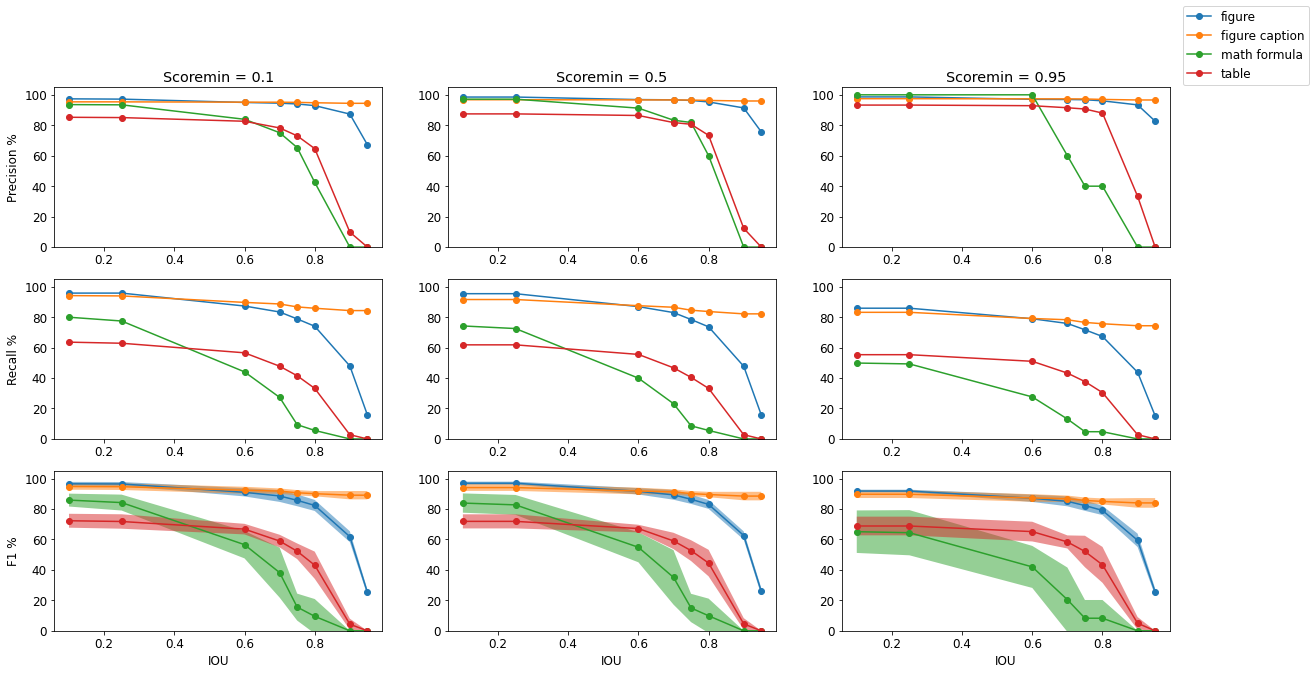

In [141]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [9]:
scoremin = 0.1 

What IOU cut-offs for each label? for reference:

In [10]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [11]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.8] # fig, fig+caption, math formula, table

In [22]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox2,boxes_sq4,labels_sq4, 
                                              scores_sq4,n_folds_cv=n_folds_cv)

In [46]:
TPs.shape

(4, 1, 4, 5)

In [45]:
TPs[0,0,:,:].sum(axis=1)

array([241.,  79., 373., 373.])

In [41]:
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
#TP1 = TPs[:,0,:,:].sum(axis=2) # sum across all CV
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [42]:
print('SCORE = ', scoremin, ' N_CV = ', n_folds_cv)

labelsMetric = ['Metric']
labelsMetric.extend(LABELS)
spacing = '%-15s'
strOut = ' '.join([spacing % (i,) for i in labelsMetric])
print(strOut)

out = ['iou cut']
for i in range(len(LABELS)):
    out.append( str(ioumin_per_label[i]) )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['# of objs']
for i in range(len(LABELS)):
    out.append( str(totalTrue[i]) )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

print('--------------------------------------------------------------------------------------------')

out = ['TP']
for i in range(len(LABELS)):
    out.append( str(round(TP[i]/totalTrue[i]*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['FP']
for i in range(len(LABELS)):
    out.append( str(round(FP[i]/totalTrue[i]*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

out = ['FN']
for i in range(len(LABELS)):
    out.append( str(round(FN[i]/totalTrue[i]*100,1))+'%' )
strOut = ' '.join([spacing % (i,) for i in out])
print(strOut)

# print('--------------------------------------------------------------------------------------------')
# out = ['Precision'] # accuracy of positive predictions => number of true positives out of all of the things we label as positive
# for i in range(len(LABELS)):
#     iind = np.where(iouminVec == ioumin_per_label[i])[0]
#     out.append( str(np.round(precision[i,sind,iind][0],1))+'+/-' +str(np.round(precision_std[i,sind,iind][0],1))+ '%' )
# strOut = ' '.join([spacing % (i,) for i in out])
# print(strOut)

# out = ['Recall'] # true positive rate => number of true positives over all of the things that SHOULD be positive
# for i in range(len(LABELS)):
#     iind = np.where(iouminVec == ioumin_per_label[i])[0]
#     out.append( str(np.round(recall[i,sind,iind][0],1))+'+/-' +str(np.round(recall_std[i,sind,iind][0],1))+ '%' )
# strOut = ' '.join([spacing % (i,) for i in out])
# print(strOut)

# out = ['F1']
# for i in range(len(LABELS)):
#     iind = np.where(iouminVec == ioumin_per_label[i])[0]
#     out.append( str(np.round(f1[i,sind,iind][0],1))+'+/-' +str(np.round(f1_std[i,sind,iind][0],1))+ '%' )
# strOut = ' '.join([spacing % (i,) for i in out])
# print(strOut)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              47.9%           82.7%           3.5%            32.1%          
FP              6.2%            4.1%            16.7%           17.9%          
FN              52.1%           17.3%           96.5%           67.9%          
